<a href="https://colab.research.google.com/github/yc2454/gym-futbol/blob/master/2v2_training_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# git & pip

In [0]:
! git clone https://github.com/yc2454/gym-futbol.git

Cloning into 'gym-futbol'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 1531 (delta 33), reused 45 (delta 20), pack-reused 1464
Receiving objects: 100% (1531/1531), 77.11 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (819/819), done.


In [0]:
%cd /content/gym-futbol/

/content/gym-futbol


In [0]:
! git checkout master

Already on 'master'
Your branch is up to date with 'origin/master'.


In [0]:
! git pull

Already up to date.


In [0]:
! pip install -e .

Obtaining file:///content/gym-futbol
     |████████████████████████████████| 542kB 4.7MB/s 
  Running setup.py develop for gym-futbol


In [0]:
%tensorflow_version 1.14

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
! pip install keras tensorflow gym numpy stable-baselines[mpi]==2.10.0

     |████████████████████████████████| 256kB 4.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=5a149cf3670f0b6876c8e9f70476443354dbeb6b96c8db553653dbd64b9b811a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


# env

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pwd

/content/gym-futbol


In [0]:
%cd /content/drive/My\ Drive

/content/drive/My Drive


In [0]:
%mkdir cs4701

In [0]:
%cd cs4701

/content/drive/My Drive/cs4701


## import

In [0]:
import gym
import gym_futbol, random
import numpy as np

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import pymunk
from pymunk.vec2d import Vec2d
import pymunk.matplotlib_util

Loading chipmunk for Linux (64bit) [/usr/local/lib/python3.6/dist-packages/pymunk/libchipmunk.so]


## Test v1

In [0]:
# 2v2
env = gym.make("Futbol2v2-v1")

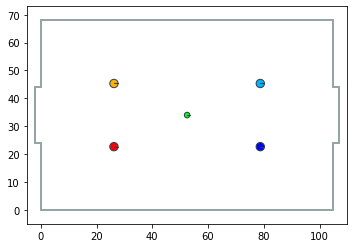

In [0]:
env.render()

In [0]:
ob = env.reset()
done = False
total_reward = 0
while not done:
    action = np.reshape(env.random_action(), -1)
    ob, reward, done, info = env.step(action)

    plt.clf()
    title_str = ("reward : " + str(reward))
    padding = 5
    ax = plt.axes(xlim=(0 - padding, env.width + padding), ylim=(0 - padding, env.height + padding))
    ax.set_aspect("equal")
    o = pymunk.matplotlib_util.DrawOptions(ax)
    env.space.debug_draw(o)
    plt.title(title_str, loc = 'left')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    total_reward += reward

In [0]:
total_reward

79.14266257181981

# Baseline

## import

In [0]:
import os, time, gym
from stable_baselines.common.policies import MlpPolicy, FeedForwardPolicy, register_policy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines.common import make_vec_env
from stable_baselines import PPO2
from stable_baselines.bench import Monitor
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.common.evaluation import evaluate_policy
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
def action_key_string(action_key):
      if action_key == 0: return "noop "
      elif action_key == 1: return "dash "
      elif action_key == 2: return "shoot"
      elif action_key == 3: return "press"
      elif action_key == 4: return "pass "

In [0]:
def arrow_key_string(arrow_key):
      if arrow_key == 0: return "noop "
      elif arrow_key == 1: return "up   "
      elif arrow_key == 2: return "right"
      elif arrow_key == 3: return "down "
      elif arrow_key == 4: return "left "

In [0]:
log_dir = "/tmp/gym/{}".format(int(time.time()))
os.makedirs(log_dir, exist_ok=True)

In [0]:
env = gym.make("Futbol2v2-v1")
check_env(env, warn=True)

## Training

In [0]:
%cd /content/

/content


In [0]:
!pwd

/content/drive/My Drive/cs4701


In [0]:
# Custom MLP policy 
class CustomPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
                                           net_arch=[256, 256, dict(pi=[128, 128],
                                                                    vf=[128, 128])],
                                           feature_extraction="mlp")

In [0]:
# Separate evaluation env
eval_env = gym.make("Futbol2v2-v1")
# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=10000, n_eval_episodes = 10,
                             deterministic=True, render=False)

In [0]:
num_envs = 8
env = gym.make("Futbol2v2-v1")
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env] * num_envs)

In [0]:
model = PPO2(CustomPolicy, env, verbose=1, tensorboard_log="./PPO2_Futbol2v2_tensorboard/")

In [0]:
# model training and save the best model
model.learn(total_timesteps=10**5, reset_num_timesteps=False, callback=eval_callback, tb_log_name="test")

In [0]:
# model training
model.learn(total_timesteps=10**5, reset_num_timesteps=False, tb_log_name="test")

In [0]:
%tensorboard --logdir ./PPO2_Futbol_tensorboard_5_layer/

In [0]:
model.set_env(env)

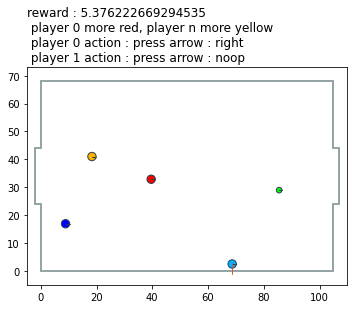

In [0]:
env = gym.make("Futbol2v2-v1")
ob = env.reset()
done = False
total_reward = 0
while not done:
    action, _states = model.predict(ob)
    ob, reward, done, info = env.step(action)

    plt.clf()
    title_str = "reward : " + str(reward) + "\n player 0 more red, player n more yellow"
    for i in range(env.number_of_player):
          title_str += "\n player " + str(i) + " action : " + action_key_string(action[2*i+1]) + " arrow : " + arrow_key_string(action[2*i])
    
    padding = 5
    ax = plt.axes(xlim=(0 - padding, env.width + padding), ylim=(0 - padding, env.height + padding))
    ax.set_aspect("equal")
    o = pymunk.matplotlib_util.DrawOptions(ax)
    env.space.debug_draw(o)
    plt.title(title_str, loc = 'left')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    total_reward += reward

In [0]:
total_reward

-244.57366071642656

# Parameter optimization
save in mounted google drive (check directory)

In [0]:
def create_custom_policy(net_arch):
    # Custom MLP policy 
    class CustomPolicy(FeedForwardPolicy):
        def __init__(self, *args, **kwargs):
            super(CustomPolicy, self).__init__(*args, **kwargs, net_arch=net_arch, feature_extraction="mlp")
    return CustomPolicy

In [0]:
%cd /content/drive/My Drive/cs4701

/content/drive/My Drive/cs4701


In [0]:
!ls

051619-2v2-test0


In [0]:
%mkdir 051619-2v2-test1

In [0]:
%cd 051619-2v2-test1

/content/drive/My Drive/cs4701/051619-2v2-test1


In [0]:
%mkdir raw_model trained_model

In [0]:
!pwd

/content/drive/My Drive/cs4701/051619-2v2-test1


In [0]:
# monitor log dir
log_dir = "/tmp/gym/{}".format(int(time.time()))
os.makedirs(log_dir, exist_ok=True)

In [0]:
env_num_list = [4, 8, 16]
net_arch_list = [
                 [512, dict(pi=[256],vf=[256])],
                 [512, 512, dict(pi=[256, 256],vf=[256, 256])], 
                 [512, 512, 256, dict(pi=[256, 256, 128],vf=[256, 256, 128])], 
                 ]

training_time_step = 10 ** 6

In [0]:
model_dict = {}

model_id = 0

for env_num in env_num_list:

      for net_arch in net_arch_list:

            model_name = "model"+str(model_id)

            # make env
            env = gym.make("Futbol2v2-v1")
            env = Monitor(env, log_dir, allow_early_resets=True)
            env = DummyVecEnv([lambda: env] * env_num)

            # make call back to save the best model in training
            eval_env = gym.make("Futbol2v2-v1")
            eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/' + model_name + '/',
                                         log_path='./logs/'+ model_name + '/', 
                                         eval_freq=10000, n_eval_episodes = 10,
                                         deterministic=True, render=False)

            # make model
            CustomPolicy = create_custom_policy(net_arch)
            model = PPO2(CustomPolicy, env, verbose=1, tensorboard_log="./PPO2_Futbol2v2_tensorboard/")

            # save the untrained_model
            model.save("./raw_model/"+ model_name)

            # model training and save the best model
            model.learn(total_timesteps=training_time_step, callback=eval_callback, tb_log_name=model_name) 

            # save the trained_model
            model.save("./trained_model/"+ model_name)

            # add the model and information to the dictionary
            temp_dict = {"model":model, "env_num":env_num, "net_arch":net_arch, "policy":CustomPolicy, 
                         "time_step":training_time_step}
                         
            model_dict[model_name] = temp_dict

            model_id += 1

In [0]:
%tensorboard --logdir ./PPO2_Futbol2v2_tensorboard/

# load & test model

In [0]:
import copy

In [0]:
!pwd

/content/drive/My Drive/cs4701/051619-2v2-test1


In [0]:
save_model_dict = {}

for model_name in model_dict:

      temp_dict = {}

      temp_dict[model_name] = copy.copy(model_dict[model_name])

      print(temp_dict)

In [0]:
current_model = model_dict["model1"]['model']

In [0]:
current_model

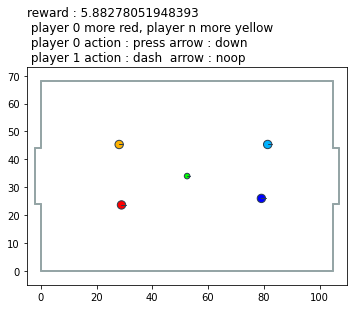

In [0]:
env = gym.make("Futbol2v2-v1")
ob = env.reset()
done = False
total_reward = 0
while not done:
    action, _states = current_model.predict(ob)
    ob, reward, done, info = env.step(action)

    plt.clf()
    title_str = "reward : " + str(reward) + "\n player 0 more red, player n more yellow"
    for i in range(env.number_of_player):
          title_str += "\n player " + str(i) + " action : " + action_key_string(action[2*i+1]) + " arrow : " + arrow_key_string(action[2*i])
    
    padding = 5
    ax = plt.axes(xlim=(0 - padding, env.width + padding), ylim=(0 - padding, env.height + padding))
    ax.set_aspect("equal")
    o = pymunk.matplotlib_util.DrawOptions(ax)
    env.space.debug_draw(o)
    plt.title(title_str, loc = 'left')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    total_reward += reward

In [0]:
total_reward

3562.5187371439283

# Load Best

In [0]:
!pwd

/content/drive/My Drive/cs4701/051619-2v2-test1


In [0]:
!ls

logs  PPO2_Futbol2v2_tensorboard  raw_model  trained_model


In [0]:
best_model = PPO2.load("logs/model1/best_model")

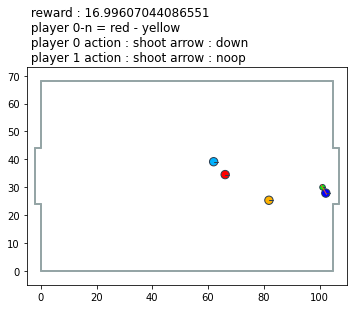

In [0]:
env = gym.make("Futbol2v2-v1")
ob = env.reset()
done = False
total_reward = 0
while not done:
    action, _states = best_model.predict(ob)
    ob, reward, done, info = env.step(action)

    plt.clf()
    title_str = " reward : " + str(reward) + "\n player 0-n = red - yellow"
    for i in range(env.number_of_player):
          title_str += "\n player " + str(i) + " action : " + action_key_string(action[2*i+1]) + " arrow : " + arrow_key_string(action[2*i])
    padding = 5
    ax = plt.axes(xlim=(0 - padding, env.width + padding), ylim=(0 - padding, env.height + padding))
    ax.set_aspect("equal")
    o = pymunk.matplotlib_util.DrawOptions(ax)
    env.space.debug_draw(o)
    plt.title(title_str, loc = 'left')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    total_reward += reward

In [0]:
total_reward

5591.258091320053

In [0]:
env = gym.make("Futbol2v2-v1")
evaluate_policy(best_model, env, n_eval_episodes=10, return_episode_rewards=True)

In [0]:
env = gym.make("Futbol2v2-v1")

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=10)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:1562.63 +/- 1439.21
